# Identify Fraud from Enron Email
https://github.com/udacity/ud120-projects/tree/master/final_project

## Project Overview

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. 

In this project, we will attempt to identify "persons of interest" based on financial and email data made public as a result of the Enron scandal. We will build a "persons of interest" classifier to predict individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity.


## Resources

- **poi_id.py** : Starter code for the POI identifier, you will write your analysis here. You will also submit a version of this file for your evaluator to verify your algorithm and results. 

- **final_project_dataset.pkl** : The dataset for the project, more details below. 

- **tester.py** : When you turn in your analysis for evaluation by Udacity, you will submit the algorithm, dataset and list of features that you use (these are created automatically in poi_id.py). The evaluator will then use this code to test your result, to make sure we see performance that’s similar to what you report. You don’t need to do anything with this code, but we provide it for transparency and for your reference. 

## Dataset

As preprocessing to this project, we've combined the Enron email and financial data into a dictionary, where each key-value pair in the dictionary corresponds to one person. The dictionary key is the person's name, and the value is another dictionary, which contains the names of all the features and their values for that person. The features in the data fall into three major types, namely financial features, email features and POI labels.

- **financial features**:  
`['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees']`  
(all units are in US dollars)

- **email features**:  
`['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']`  
(units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)

- **POI label**:  
`[‘poi’]`  
(boolean, represented as integer)

You are encouraged to make, transform or rescale new features from the starter features. If you do this, you should store the new feature to `my_dataset`, and if you use the new feature in the final algorithm, you should also add the feature name to `my_feature_list`.

In [3]:
#!/usr/bin/python

import sys
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("./tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','salary'] # You will need to use more features

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    try:
        data_dict = pickle.load(data_file)
        print "Successfully loaded data with {} samples & {} features".format(len(data_dict.keys()), 
                                                                              len(data_dict.values()[0]))
    except:
        print "Dataset could not be loaded. Is the dataset missing?"

Successfully loaded data with 146 samples & 21 features


Create Features and Labels
----------------

In [4]:
### Store to my_dataset for easy export below.
my_dataset = data_dict

### Extract features and labels from dataset for local testing
features_list = ['poi','salary']
features_list.extend([i for i in my_dataset.values()[0].keys() if i not in ['salary', 'poi', 'email_address']])

data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

# Convert with pandas
labels = pd.Series(labels)
features = pd.DataFrame(features, columns = features_list[1:])

print "Features: {}".format(features.shape)
print "Labels: {}".format(labels.shape)

Features: (145, 19)
Labels: (145,)


In [72]:
# separate financial and email features
fin_feats = ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 
             'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 
             'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees']

# removed 'email_address'
email_feats = ['to_messages', 'from_poi_to_this_person', 'from_messages', 
               'from_this_person_to_poi', 'shared_receipt_with_poi']


In [39]:
df_all = pd.concat([features, pd.Series(labels, name='target')],axis=1)
df_all.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person,target
0,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,13868,0,2195,152,65,0,-3081055,304805,47,0
1,0,0,178980,182466,257817,0,0,0,0,257817,3486,0,0,0,0,0,0,0,0,0
2,477,566,0,916197,4046157,0,1757552,465,-560222,5243487,56301,0,29,864523,0,0,-5104,0,39,0
3,267102,0,1295738,5634343,6680544,1200000,3942714,0,0,10623258,11200,0,0,2660303,0,0,-1386055,1586055,0,0
4,239671,0,260455,827696,0,400000,145796,0,-82782,63014,129142,0,0,69,0,0,-201641,0,0,0


In [41]:
sum(df_all['target']) / df_all.shape[0]

0.12413793103448276

Remove outliers
---------------

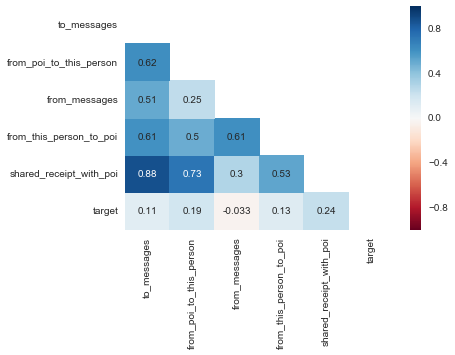

In [74]:
### Task 2: Remove outliers

corr = df_all[email_feats+['target']].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, square=False, annot=True, cmap='RdBu')

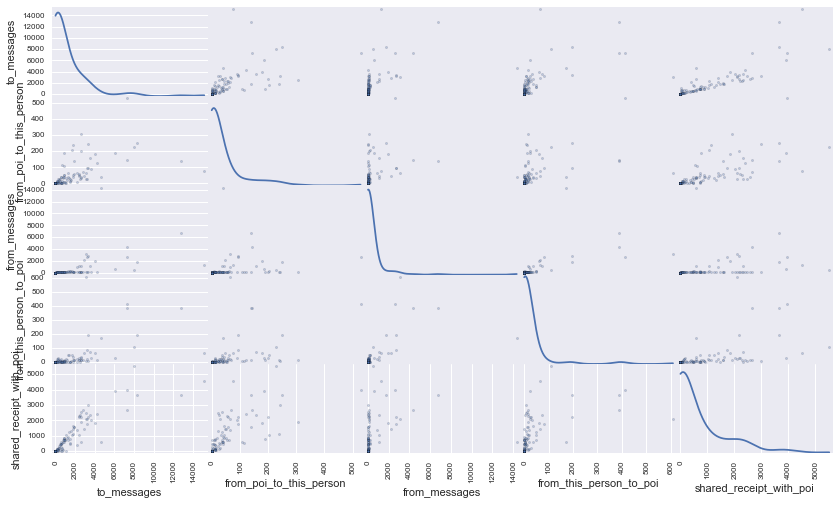

In [76]:
pd.scatter_matrix(features[email_feats], alpha = 0.3, figsize = (14,8), diagonal = 'kde');

In [79]:
# replace zeros
eng_feats = np.log(features.replace(0, 0.36787944117144233))

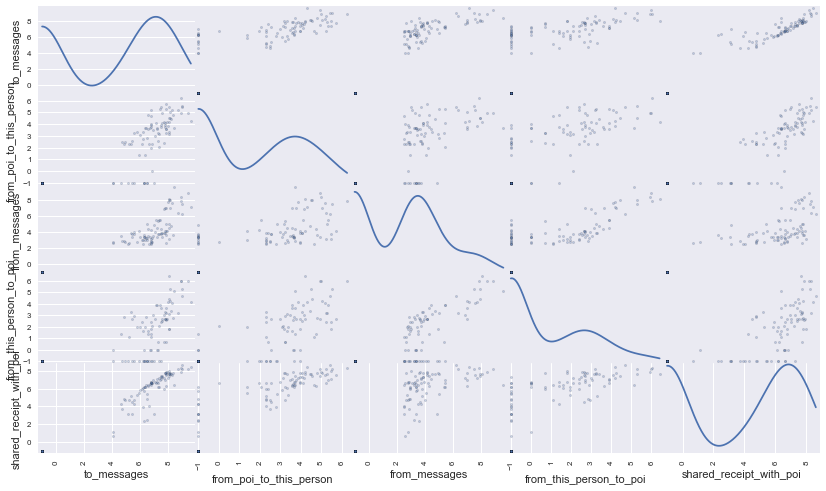

In [80]:
pd.scatter_matrix(eng_feats[email_feats], alpha = 0.3, figsize = (14,8), diagonal = 'kde');

Create new features
-------------------

In [38]:
[i for i in my_dataset.values()[0].keys() if i not in ['salary', 'poi', 'email_address']]

['to_messages',
 'deferral_payments',
 'total_payments',
 'exercised_stock_options',
 'bonus',
 'restricted_stock',
 'shared_receipt_with_poi',
 'restricted_stock_deferred',
 'total_stock_value',
 'expenses',
 'loan_advances',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'director_fees',
 'deferred_income',
 'long_term_incentive',
 'from_poi_to_this_person']

In [54]:
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
my_dataset = data_dict

### Extract features and labels from dataset for local testing
features_list = ['poi','salary']
features_list.extend([i for i in my_dataset.values()[0].keys() if i not in ['salary', 'poi', 'email_address']])

data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

# Convert with pandas
import pandas as pd

labels = pd.Series(labels)
features = pd.DataFrame(features, columns = features_list[1:])

print "Features: {}".format(features.shape)
print "Labels: {}".format(labels.shape)

Features: (145, 19)
Labels: (145,)


In [25]:
features.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
0,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,13868,0,2195,152,65,0,-3081055,304805,47
1,0,0,178980,182466,257817,0,0,0,0,257817,3486,0,0,0,0,0,0,0,0
2,477,566,0,916197,4046157,0,1757552,465,-560222,5243487,56301,0,29,864523,0,0,-5104,0,39
3,267102,0,1295738,5634343,6680544,1200000,3942714,0,0,10623258,11200,0,0,2660303,0,0,-1386055,1586055,0
4,239671,0,260455,827696,0,400000,145796,0,-82782,63014,129142,0,0,69,0,0,-201641,0,0


In [56]:
features[features.expenses==94299]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
92,365788,807,0,1061827,0,600000,585062,702,0,585062,94299,0,29,1740,1,0,0,0,38


In [53]:
labels[92]

0.0

In [51]:
data_dict.items()[0]

('METTS MARK',
 {'bonus': 600000,
  'deferral_payments': 'NaN',
  'deferred_income': 'NaN',
  'director_fees': 'NaN',
  'email_address': 'mark.metts@enron.com',
  'exercised_stock_options': 'NaN',
  'expenses': 94299,
  'from_messages': 29,
  'from_poi_to_this_person': 38,
  'from_this_person_to_poi': 1,
  'loan_advances': 'NaN',
  'long_term_incentive': 'NaN',
  'other': 1740,
  'poi': False,
  'restricted_stock': 585062,
  'restricted_stock_deferred': 'NaN',
  'salary': 365788,
  'shared_receipt_with_poi': 702,
  'to_messages': 807,
  'total_payments': 1061827,
  'total_stock_value': 585062})

Train classifiers
----------------------------

In [57]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()



In [59]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, stratify=labels, test_size=0.2, random_state=42)

clf.fit(X_train, y_train)

print "Training accuracy:"
print clf.score(X_train, y_train)

print "Test accuracy:"
print clf.score(X_test, y_test)


Training accuracy:
0.344827586207
Test accuracy:
0.344827586207


In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [62]:
# loop thru models, then thru train sizes
for clf in [GaussianNB(), RandomForestClassifier(max_depth=6), SVC()]:
    print "\n{}: \n".format(clf.__class__.__name__)
    clf.fit(X_train, y_train)

    print "Training accuracy:"
    print clf.score(X_train, y_train)

    print "Test accuracy:"
    print clf.score(X_test, y_test)


GaussianNB: 

Training accuracy:
0.344827586207
Test accuracy:
0.344827586207

RandomForestClassifier: 

Training accuracy:
0.974137931034
Test accuracy:
0.862068965517

SVC: 

Training accuracy:
1.0
Test accuracy:
0.862068965517


In [ ]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)

---

Enron Submission Free-Response Questions
----------------------------------------


1. Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?  [relevant rubric items: “data exploration”, “outlier investigation”]

2. What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.  [relevant rubric items: “create new features”, “properly scale features”, “intelligently select feature”]

3. What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?  [relevant rubric item: “pick an algorithm”]

4. What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).  [relevant rubric item: “tune the algorithm”]

5. What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?  [relevant rubric item: “validation strategy”]
Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance. [relevant rubric item: “usage of evaluation metrics”]